In [7]:
import numpy as np
import netCDF4 as nc
import geopandas as gpd

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [8]:
domain = "N01"

# hide

In [9]:
# Read PALM output data
file_N01 = r"F:\Simulation_Comparison\simulation_data\_kn_4096x4096_base - backup\konstanz_4096x4096_v4_3d.000.nc"
file_N02 = r"F:\Simulation_Comparison\simulation_data\_kn_4096x4096_base - backup\konstanz_4096x4096_v4_3d_N02.000.nc"
file_N03 = r"F:\Simulation_Comparison\simulation_data\_kn_4096x4096_base - backup\konstanz_4096x4096_v4_3d_N03.000.nc"

# Load static driver for mask (building)
fn_N01 = r"F:\Simulation_Comparison\simulation_data\_kn_4096x4096_static - backup\konstanz_4096x4096_v4_static"
fn_N02 = r"F:\Simulation_Comparison\simulation_data\_kn_4096x4096_static - backup\konstanz_4096x4096_v4_static_N02"
fn_N03 = r"F:\Simulation_Comparison\simulation_data\_kn_4096x4096_static - backup\konstanz_4096x4096_v4_static_N03"


if domain == "N01":
    ds = nc.Dataset(file_N01, mode="r")
    ds_topo = nc.Dataset(fn_N01, mode="r")
if domain == "N02":
    ds = nc.Dataset(file_N02, mode="r")
    ds_topo = nc.Dataset(fn_N02, mode="r")
if domain == "N03":
    ds = nc.Dataset(file_N03, mode="r")
    ds_topo = nc.Dataset(fn_N03, mode="r")

# Read Variable Data from output data        
variable_name1 = 'wspeed'
variable_name2 = 'wdir'
variable_name3 = 'u'
variable_name4 = 'v'
variable_name5 = 'theta'

var1=ds[variable_name1]
var2=ds[variable_name2]
var3=ds[variable_name3]
var4=ds[variable_name4]
var5=ds[variable_name5]

#create building mask
bmask = ds_topo['building_id'][:,:]>0
bmask_2d = ds_topo['buildings_2d']

#define grid spacing
dx = ds['x'][1]-ds['x'][0]
dy = ds['y'][1]-ds['y'][0]
#define number of cells
nx = np.shape(ds['x'])[0]
ny = np.shape(ds['y'])[0]

#coordinates of origin in PALM
origin_x, origin_y, origin_z = ds.origin_x, ds.origin_y, ds.origin_z

#vector for coordinate at cell edges
x = np.arange(nx+1)*dx + origin_x
y = np.arange(nx+1)*dy + origin_y
#vector for coordinates at cell centers
xc = np.arange(nx)*dx + origin_x + dx/2
yc = np.arange(nx)*dy + origin_y + dy/2

In [10]:
def band_index_to_time_hr_min(band_index):
    # Calculate the total seconds
    total_seconds = (band_index+1) * 10 * 60
    # Calculate hours, minutes, and seconds
    hours = total_seconds // 3600
    total_seconds %= 3600
    minutes = total_seconds // 60
    # Format string for return
    time_str = f"{hours:02d}:{minutes:02d}"
    return time_str

# show

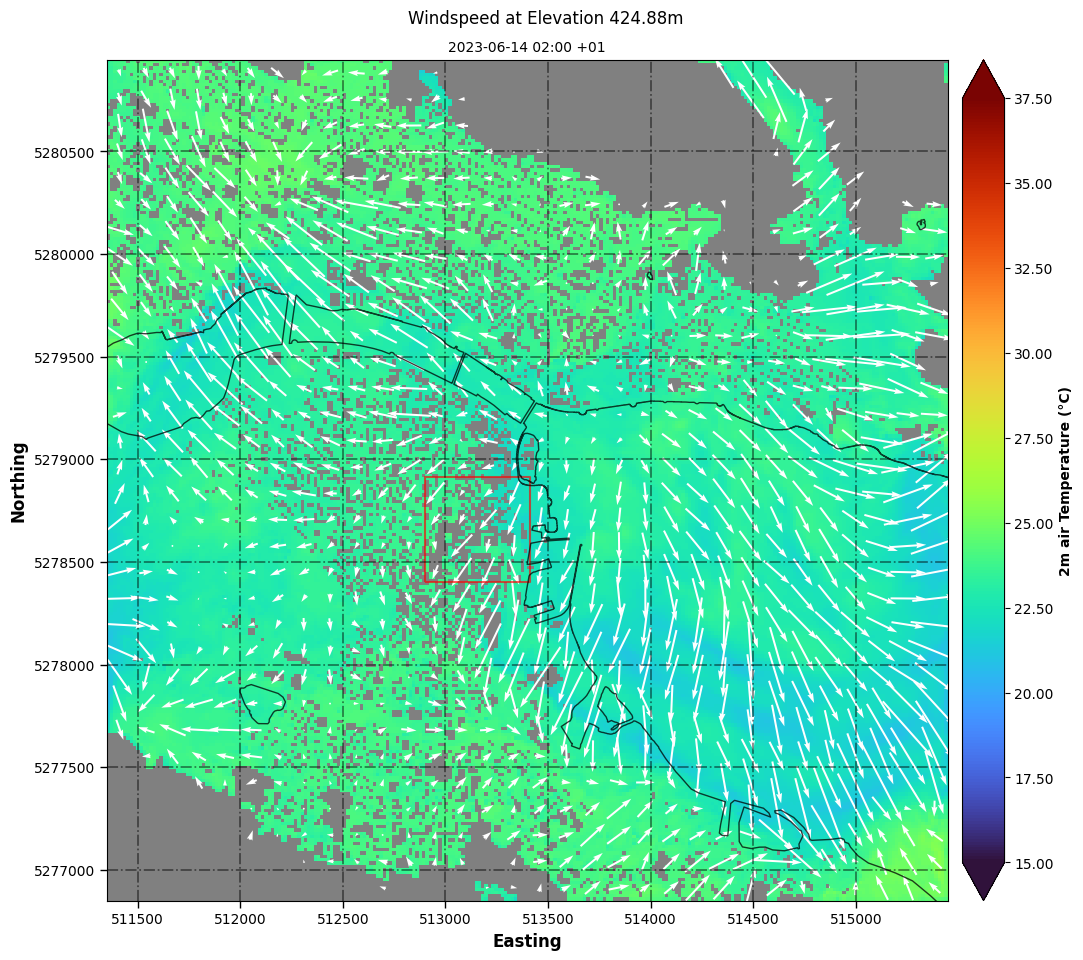

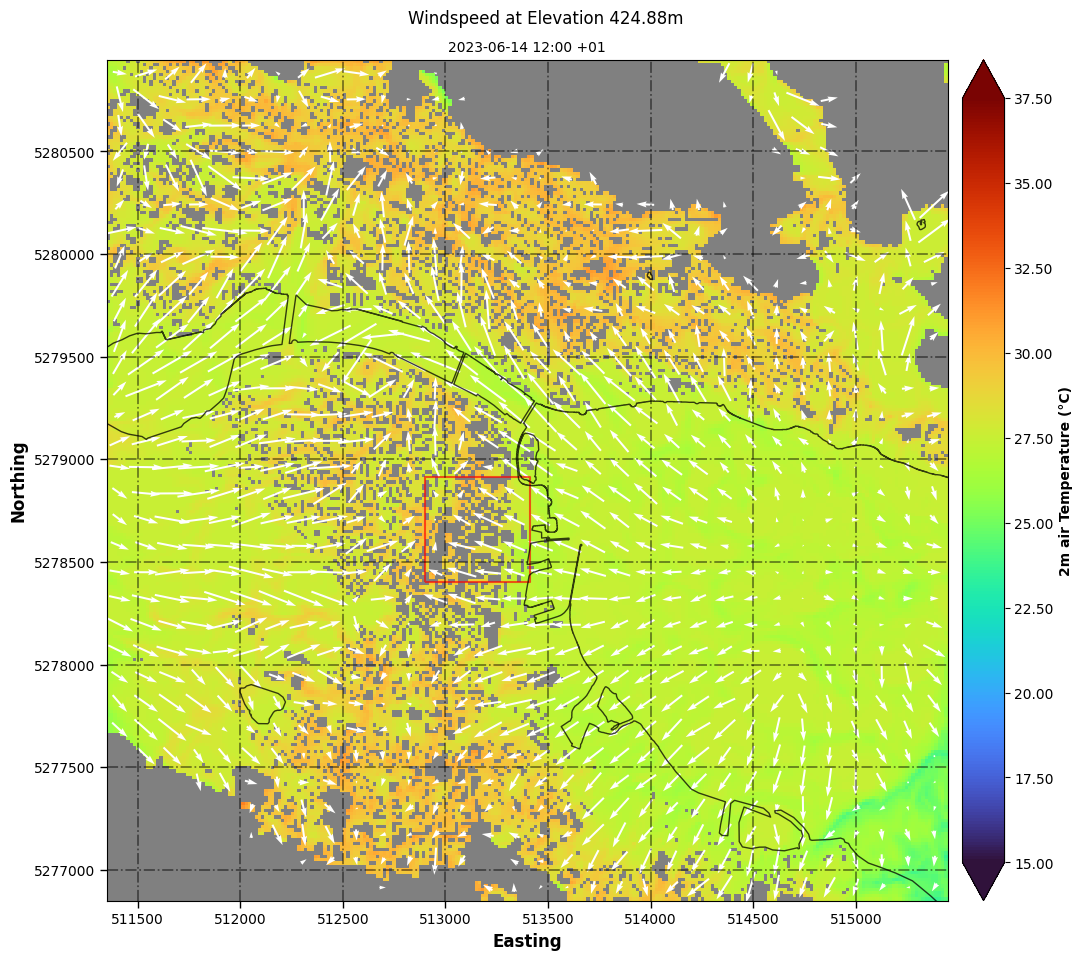

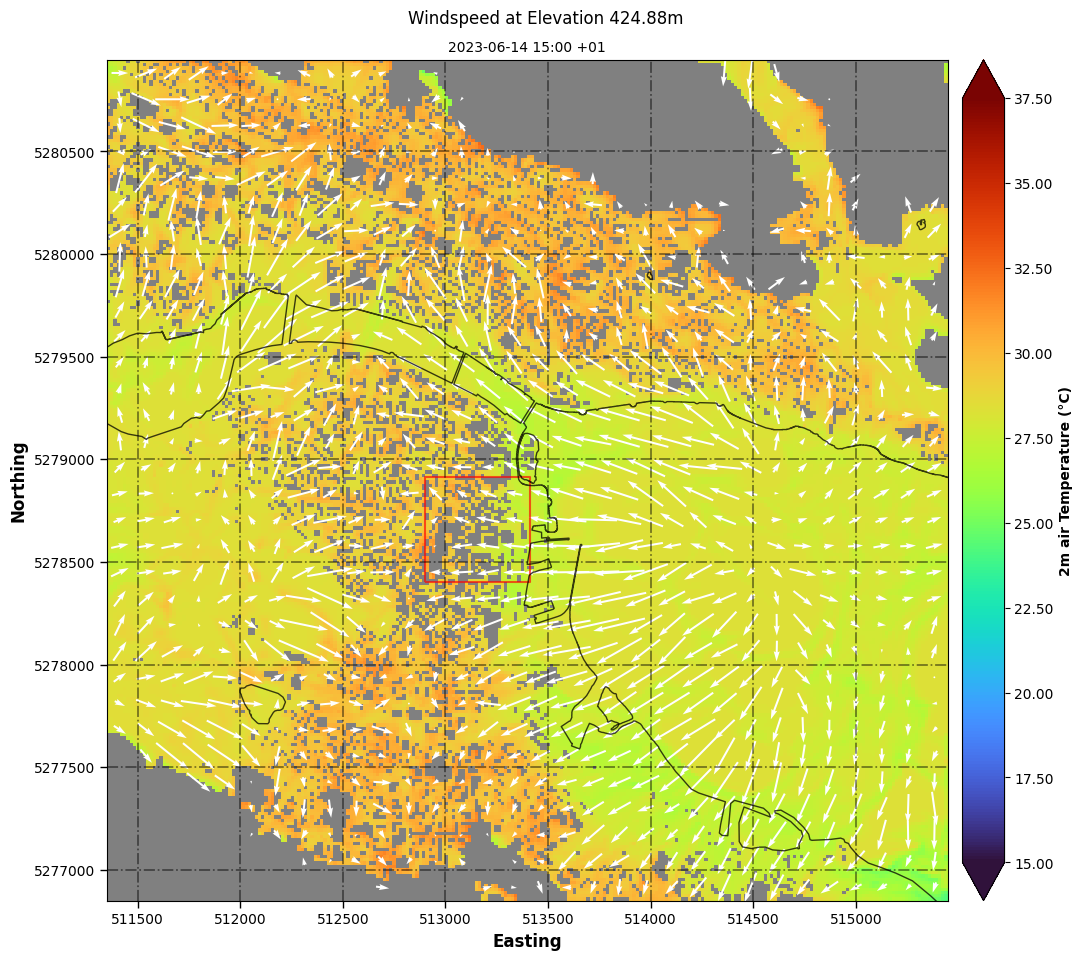

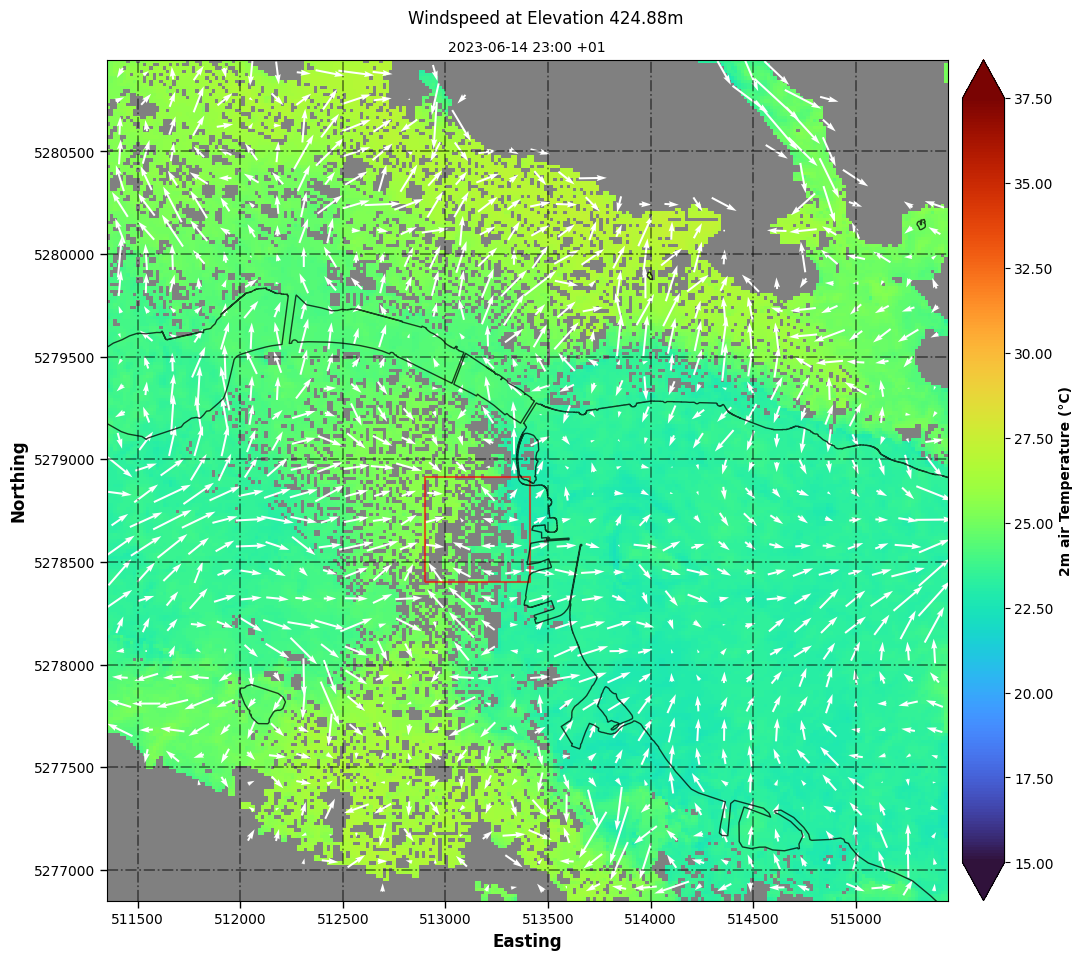

In [14]:
bands = [11, 71, 89, 137] #2am, 12pm, 15pm, 23pm

if domain == "N01":
    level_index = 2
elif domain == "N02":
    level_index = 4
elif domain == "N03":
    level_index = 16

for band_index in bands:
    X, Y = np.meshgrid(xc, yc)

    # Extract wind speed and wind direction data
    wspeed_data = var1[band_index, level_index, :, :]
    wdir_data = var2[band_index, level_index, :, :]
    # Convert wind direction from degrees to radians
    wdir_rad = np.radians(wdir_data)

    u_data = var3[band_index, level_index, :, :]
    v_data = var4[band_index, level_index, :, :]
    u = u_data
    v = v_data

    # # Calculate u and v components for quiver plot
    # u = wspeed_data * np.cos(wdir_rad)
    # v = wspeed_data * np.sin(wdir_rad)

    # reduced grid spacing
    grid_size = 8
    rows, cols = X.shape
    reduced_rows = rows // grid_size
    reduced_cols = cols // grid_size

    # Create reduced grids for X and Y by averaging over grid_spacing cells
    X_reduced = np.mean(X.reshape(reduced_rows, grid_size, reduced_cols, grid_size), axis=(1, 3))
    Y_reduced = np.mean(Y.reshape(reduced_rows, grid_size, reduced_cols, grid_size), axis=(1, 3))
    # Create reduced u and v by averaging over grid_spacing cells
    u_reduced = np.mean(u.reshape(reduced_rows, grid_size, reduced_cols, grid_size), axis=(1, 3))
    v_reduced = np.mean(v.reshape(reduced_rows, grid_size, reduced_cols, grid_size), axis=(1, 3))
    
    # Create the quiver plot for the reduced data
    fig, ax = plt.subplots(figsize=(10, 10), facecolor='w', edgecolor='k')
    fig.tight_layout(rect=[0, 0.05, 1, 0.95])
    plt.rcParams.update({'font.size': 10})

    cmap = plt.get_cmap('turbo')
    # set mask color
    # cmap.set_bad('#474747')
    cmap.set_bad('grey')
    if domain == "N01":
        multiplier = 16
    elif domain == "N02":
        multiplier = 8
    elif domain == "N03":
        multiplier = 2
    plt.suptitle(f"Windspeed at Elevation {ds.origin_z + level_index*multiplier:.2f}m")

    #plot
    # toplot = np.ma.masked_array(var1[band_index, level_index, :, :], mask=bmask)
    # pcm = ax.pcolormesh(x, y, toplot, cmap=cmap, vmin=0, vmax=5, alpha=1.0, facecolor='black')
    toplot = np.ma.masked_array(var5[band_index, level_index, :, :]-273.15, mask=bmask)
    pcm = ax.pcolormesh(x, y, toplot, cmap=cmap, vmin=15, vmax=37.5, alpha=1.0, facecolor='black')

    if band_index == 11:
        scale = 20
    elif band_index == 71 or band_index == 89:
        scale = 45
    elif band_index == 137:
        scale = 8
    
    plt.quiver(X_reduced, Y_reduced, u_reduced, v_reduced, pivot='middle', color='w', scale=scale, angles='xy')
    # plt.quiver(X_reduced, Y_reduced, u_reduced, v_reduced, pivot='middle', scale=20, width=0.005, headwidth=3, color='w', angles='xy')

    ax.grid(True, linestyle='-.', linewidth=1.25, color='k', alpha=0.5)
    ax.tick_params(axis='x', labelsize=10, length=5, width=1)
    ax.tick_params(axis='y', labelrotation=0, labelsize=10, length=5, width=1)
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, pos: f'{y:.0f}'))

    ax.set_xlim(x[0] - 0, x[-1] + 0)
    ax.set_ylim(y[0] - 0, y[-1] + 0)
    ax.set_title(f'2023-06-14 {band_index_to_time_hr_min(band_index)} +01', fontsize=10)
    ax.set_xlabel('Easting', fontsize=12, weight="bold")
    ax.set_ylabel('Northing', fontsize=12, weight="bold")
    ax.set_aspect(1)

    # add shapefile to map
    shapefile_url = r"F:\Simulation_Comparison\web_streamlit_palm\data\area_of_interest\aoi_512x512.shp"
    gdf = gpd.read_file(shapefile_url)
    gdf.plot(ax=ax, edgecolor='red', linewidth=1.5, facecolor='none', hatch=None, alpha=0.65)

    shapefile_url = r"F:\Simulation_Comparison\web_streamlit_palm\data\shapefile_other\soil.shp"
    gdf = gpd.read_file(shapefile_url)
    gdf.plot(ax=ax, edgecolor='k', linewidth=1.0, facecolor='none', hatch=None, alpha=0.750)

    # Add colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.15)
    cb = fig.colorbar(pcm, cax=cax, extend='both', format='%.2f', spacing='uniform')
    cb.ax.tick_params(labelsize=10, rotation=0)
    cb.ax.xaxis.set_ticks_position("top")
    cb.ax.set_ylabel(f"2m air Temperature (°C)", fontsize=10, weight="bold")

    plt.show()

# hide

In [12]:
# band = 6*15
# level = 6
# X, Y = np.meshgrid(xc, yc)
# # Create a boolean mask for locations where buildings exist
# bmask = ds_topo['building_id'][:, :] > 0

# # Extract wind speed and wind direction data
# wspeed_data = var1[band, level, :, :]
# wdir_data = var2[band, level, :, :]
# masked = np.copy(wspeed_data)
# masked[bmask] = np.nan

# # Convert wind direction from degrees to radians
# wdir_rad = np.radians(wdir_data)

# # Calculate u and v components for quiver plot
# u = wspeed_data * np.cos(wdir_rad)
# v = wspeed_data * np.sin(wdir_rad)

# # reduced grid spacing
# grid_size = 4
# rows, cols = X.shape
# reduced_rows = rows // grid_size
# reduced_cols = cols // grid_size

# # Create reduced grids for X and Y by averaging over grid_spacing cells
# X_reduced = np.mean(X.reshape(reduced_rows, grid_size, reduced_cols, grid_size), axis=(1, 3))
# Y_reduced = np.mean(Y.reshape(reduced_rows, grid_size, reduced_cols, grid_size), axis=(1, 3))
# # Create reduced u and v by averaging over grid_spacing cells
# u_reduced = np.mean(u.reshape(reduced_rows, grid_size, reduced_cols, grid_size), axis=(1, 3))
# v_reduced = np.mean(v.reshape(reduced_rows, grid_size, reduced_cols, grid_size), axis=(1, 3))


# # Create the quiver plot for the reduced data
# fig, ax = plt.subplots(figsize=(8, 8), facecolor='w', edgecolor='k')
# fig.tight_layout(rect=[0, 0.05, 1, 0.95])
# plt.rcParams.update({'font.size': 10})

# # Define plot color and mask
# cmap1 = plt.get_cmap('jet') #Other cmap: jet, turbo, rainbow,
# cmap2 = plt.get_cmap('Greys') #Other cmap: Greys, BuPu, Purples, copper,
# new_colors = cmap2(np.linspace(0.6, 1, 10))
# custom_cmap = plt.cm.colors.ListedColormap(new_colors)
# plt.suptitle(f"{variable_name1}")

# #plot
# toplot = np.ma.masked_array(var1[band, level, :, :], mask=bmask)
# pcm = ax.pcolormesh(x, y, toplot, cmap=cmap, vmin=0, vmax=5, alpha=1.0, facecolor='black')

# # plt.quiver(X_reduced, Y_reduced, u_reduced, v_reduced, pivot='middle', scale=25, color='w', angles='xy')
# plt.quiver(X_reduced, Y_reduced, u_reduced, v_reduced, pivot='middle', scale=20, width=0.005, headwidth=3, color='w', angles='xy')
# pcm2 = ax.pcolormesh(x, y, bmask_2d, cmap=custom_cmap,
#                          vmin=(np.min(bmask_2d[:]>0)//5*5), vmax= ((np.max(bmask_2d)+5-1)//5)*5,)

# ax.grid(True, linestyle='-.', linewidth=1.25, color='k', alpha=0.5)
# ax.tick_params(axis='x', labelsize=10, length=5, width=1)
# ax.tick_params(axis='y', labelrotation=0, labelsize=10, length=5, width=1)
# ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, pos: f'{y:.0f}'))

# ax.set_xlim(x[0]+0, x[0]+200)
# ax.set_ylim(y[0]+0, y[0]+200)
# ax.set_title(f'2023-06-14 Band:{band} +01', fontsize=10)
# ax.set_xlabel('Easting', fontsize=12, weight="bold")
# ax.set_ylabel('Northing', fontsize=12, weight="bold")
# ax.set_aspect(1)

# # Add colorbar
# divider = make_axes_locatable(ax)
# cax = divider.append_axes("right", size="5%", pad=0.15)
# cb = fig.colorbar(pcm, cax=cax, extend='both', format='%.2f', spacing='uniform')
# cb.ax.tick_params(labelsize=10, rotation=0)
# cb.ax.xaxis.set_ticks_position("top")

# plt.show()
